In [1]:
from functools import partial

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

from statsmodels.api import OLS

import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error


from ISLP import load_data
from ISLP.models import (ModelSpec as MS, poly)
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

from l0bnb import fit_path

# import warnings
# from sklearn.exceptions import ConvergenceWarning
# # Supress all warnings (when using l2_norm = 0)
# warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Simulated data

### Stepwise selection

In [2]:
rng = np.random.default_rng(42)

In [3]:
N = 100
x1 = rng.normal(size=N)
x1[:5]

array([ 0.30471708, -1.03998411,  0.7504512 ,  0.94056472, -1.95103519])

In [4]:
e = rng.normal(size=N)
e[:5]

array([-0.37816255,  1.2992283 , -0.35626397,  0.73751557, -0.93361768])

In [5]:
beta0, beta = 1, np.array([3, 5, 9])
beta0, beta

(1, array([3, 5, 9]))

In [6]:
x = np.array([x1, np.power(x1, 2), np.power(x1, 3)]).T
x.shape

(100, 3)

In [7]:
y = beta0 + np.dot(x, beta) + e
y

array([ 2.25489486e+00, -5.53620117e+00,  9.51470626e+00,  1.64712563e+01,
       -5.35942434e+01, -1.45062365e+01,  5.34018853e-01, -7.23589892e-02,
        1.79127338e+00, -5.23474981e+00,  1.40599905e+01,  1.08307120e+01,
        6.28333478e-01,  2.21802215e+01,  4.48711301e+00, -4.12583908e+00,
        3.47008936e+00, -5.19236833e+00,  1.51964071e+01,  6.22209616e-01,
       -4.64071649e-01, -1.38669682e+00,  2.88056305e+01,  1.98178535e+00,
        7.60203987e-01,  5.27485772e-01,  6.83447877e+00,  2.01455936e+00,
        3.08296169e+00,  3.01359027e+00,  1.18375383e+02, -1.37422506e+00,
        2.00707451e-01, -3.20252413e+00,  5.37777847e+00,  2.26949037e+01,
        1.02327612e+00, -2.49034596e+00, -1.12197936e+00,  1.04603891e+01,
        1.01016472e+01,  4.55716301e+00, -3.56686678e+00,  2.34630895e+00,
        6.19492925e-01,  1.57396050e+00,  1.27549040e+01,  1.88057848e+00,
        9.22368476e+00,  1.38539809e+00,  2.34418098e+00,  6.11509131e+00,
       -2.22754860e+01, -

In [8]:
# polynomial terms
sim = [x1]
for degree in range(2, 11):
    sim.append(np.power(x1, degree))

# y term
sim.append(y)

sim_cols = ['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'y']
Sim = pd.DataFrame(np.array(sim).T, columns=sim_cols)
Sim

,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.304717,0.092852,0.028294,0.008622,0.002627,0.000801,0.000244,0.000074,0.000023,0.000007,2.254895
1,-1.039984,1.081567,-1.124812,1.169787,-1.216560,1.265203,-1.315791,1.368402,-1.423116,1.480018,-5.536201
2,0.750451,0.563177,0.422637,0.317168,0.238019,0.178622,0.134047,0.100596,0.075492,0.056653,9.514706
3,0.940565,0.884662,0.832082,0.782627,0.736111,0.692360,0.651210,0.612505,0.576100,0.541860,16.471256
4,-1.951035,3.806538,-7.426690,14.489734,-28.269981,55.155727,-107.610764,209.952388,-409.624497,799.191808,-53.594243
...,...,...,...,...,...,...,...,...,...,...,...
95,-1.447112,2.094135,-3.030448,4.385399,-6.346166,9.183616,-13.289725,19.231727,-27.830473,40.273824,-21.039425
96,-1.322700,1.749534,-2.314108,3.060870,-4.048612,5.355097,-7.083185,9.368926,-12.392275,16.391257,-14.404075
97,-0.997247,0.994501,-0.991763,0.989033,-0.986310,0.983594,-0.980886,0.978186,-0.975493,0.972807,-6.339708
98,0.399774,0.159819,0.063892,0.025542,0.010211,0.004082,0.001632,0.000652,0.000261,0.000104,3.568323


In [9]:
ms = MS(Sim.columns.drop('y'))
y = np.array(Sim['y'])
X = ms.fit_transform(Sim)
X.shape, y.shape

((100, 11), (100,))

Estimated scale of residuals.

In [10]:
result = OLS(y, X).fit()
sigma2 = result.scale
sigma2

0.9597290861769209

Negative $C_p$ scoring function.

In [11]:
def nCp(sigma2, estimator, X, y):
    "Negative Cp statistic"

    n, p = X.shape
    yhat = estimator.predict(X)
    RSS = np.sum((y - yhat) ** 2)
    return -(RSS + 2 * p * sigma2) / n

Negative $C_p$ with fixed $\sigma^2$ 

In [12]:
neg_Cp = partial(nCp, sigma2)

Forward-stepwise selection correctly identifies 3 terms.

In [13]:
forward = Stepwise.first_peak(ms, direction='forward', max_terms=len(ms.terms))
sim_Cp = sklearn_selected(OLS, forward, scoring=neg_Cp)
sim_Cp.fit(Sim, y)
sim_Cp.selected_state_

('x', 'x2', 'x3')

For backward-stepwise, we set the `initial_terms` to all terms so it doesn't return empty.

In [14]:
backward = Stepwise.first_peak(ms, direction='backward', max_terms=len(ms.terms), initial_terms=ms.terms)
sim_Cp = sklearn_selected(OLS, backward, scoring=neg_Cp)
sim_Cp.fit(Sim, y)
sim_Cp.selected_state_

('x', 'x10', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9')

### Lasso

Take only the predictor terms.

In [15]:
X = np.asarray(Sim.drop('y', axis=1))
X.shape

(100, 10)

Standardized version of $X$, where $\mu$ is the mean and $\sigma$ is the standard deviation.


$X_z = (X - \mu) / \sigma$

In [16]:
Xz = StandardScaler().fit_transform(X)
Xz[:5]

array([[ 4.59360775e-01, -6.35549708e-01,  1.11876782e-01,
        -3.49210079e-01,  4.57818754e-02, -2.32405826e-01,
         2.83561022e-03, -1.82565855e-01, -2.56796952e-02,
        -1.57020105e-01],
       [-1.28071285e+00,  6.04171464e-01, -5.98120587e-01,
         6.15802882e-02, -1.63190086e-01, -1.21952102e-01,
        -5.17704491e-02, -1.54751728e-01, -3.92924329e-02,
        -1.50206701e-01],
       [ 1.03615076e+00, -4.58230754e-02,  3.54684059e-01,
        -2.40054205e-01,  8.61287361e-02, -2.16871980e-01,
         8.38748355e-03, -1.80522546e-01, -2.49578069e-02,
        -1.56759327e-01],
       [ 1.28216194e+00,  3.57277890e-01,  6.06789961e-01,
        -7.53870036e-02,  1.71503022e-01, -1.71993621e-01,
         2.98460392e-02, -1.70116921e-01, -2.01693435e-02,
        -1.54525623e-01],
       [-2.45963347e+00,  4.02093626e+00, -4.47835013e+00,
         4.77383365e+00, -4.80021952e+00,  4.58573331e+00,
        -4.46225334e+00,  4.08515578e+00, -3.94385794e+00,
         3.

In [17]:
K = 5
k5fold = skm.KFold(5, random_state=42, shuffle=True)
scaler = StandardScaler()

In [18]:
lassoCV = skl.LassoCV(cv=k5fold)
lassoPipe = Pipeline(steps=[
    ('scaler', scaler), 
    ('lasso', lassoCV)
])
lassoPipe.fit(X, y)

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True


In [19]:
llambdas_ = lassoPipe.named_steps['lasso'].alphas_

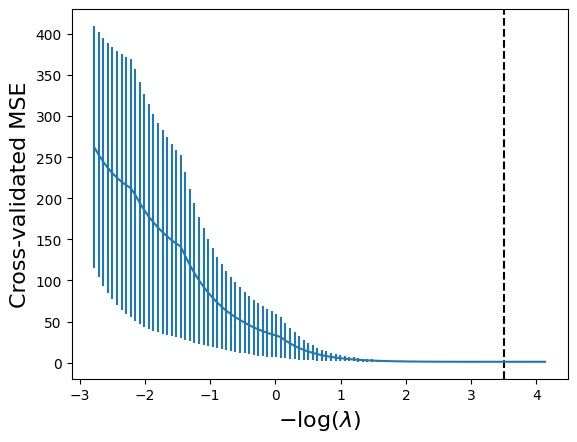

In [20]:
tunedLasso = lassoPipe.named_steps['lasso']
_, ax = subplots()
ax.errorbar(
    -np.log(tunedLasso.alphas_), 
    tunedLasso.mse_path_.mean(1),
    yerr=tunedLasso.mse_path_.std(1) / np.sqrt(K)
)
ax.axvline(-np.log(tunedLasso.alpha_), c='k', ls='--')
ax.set_xlabel("$-\\log(\\lambda)$", fontsize=16)
ax.set_ylabel("Cross-validated MSE", fontsize=16);

In [21]:
tunedLasso.coef_, -np.log(tunedLasso.alpha_)

(array([ 2.23536373,  3.79530197, 14.7533526 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 3.5048332694234445)

In [22]:
solna = skl.lasso_path(Xz, y, alphas=llambdas_)[1]
solna[:1]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01036349, 0.1768983 , 0.32757407, 0.45624095, 0.57715352,
        0.6892203 , 0.79369952, 0.89113549, 0.98272525, 1.06746882,
        1.14645663, 1.22011806, 1.28953807, 1.3536192 , 1.41332373,
        1.46899947, 1.52164976, 1.57010873, 1.61522668, 1.65729544,
        1.69726124, 1.73391406, 1.76799942, 1.79977322, 1.83014548,
        1.85788362, 1.88362725, 1.90761148, 1.93072976, 1.9517478 ,
        1.97119029, 1.98928128, 2.00614253, 2.02258903, 2.03748163,
        2.05118682, 2.06390454, 2.07708665, 2.08928517, 2.10070835,
        2.11137978, 2.12133901, 2.13062976, 2.13929539, 2.1473774 ,
        2.15491487, 2.1619444 , 2.16850019, 2.17

In [23]:
Sim_cols = Sim.columns.drop('y')
soln_path = pd.DataFrame(
    solna.T, 
    columns=Sim_cols, 
    index=-np.log(llambdas_)
)
soln_path.index.name = 'neg. log(lambda)'
soln_path

,x,x2,x3,x4,x5,x6,x7,x8,x9,x10
neg. log(lambda),,,,,,,,,,
-2.774944,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2.705169,0.000000,0.000000,1.080890,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2.635394,0.000000,0.000000,2.088931,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2.565618,0.000000,0.000000,3.029033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2.495843,0.000000,0.000000,3.905776,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3.853710,2.240989,3.806188,14.759224,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3.923485,2.242218,3.807957,14.759922,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3.993260,2.243363,3.809606,14.760572,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


We can see from the plot that $x, x^2 and x^3$ have non-zero coefficient.

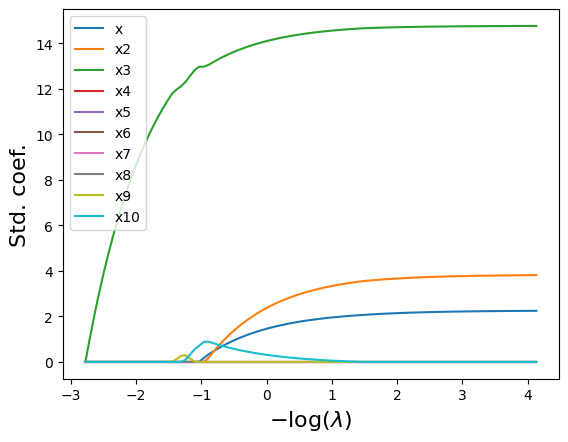

In [24]:
_, ax = subplots()
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel("$-\\log(\\lambda)$", fontsize=16)
ax.set_ylabel("Std. coef.", fontsize=16)
ax.legend(loc="upper left");

New response variable with below model.

$ y = \beta_0 + \beta_7 X^7 + \epsilon$

In [25]:
beta7 = 7
y2 = beta0 + beta7*np.power(x1, 7) + e
y2

array([ 6.23545005e-01, -6.91130878e+00,  1.58206520e+00,  6.29598262e+00,
       -7.53208969e+02, -4.36474825e+01,  4.99818515e-02,  6.58752603e-01,
        1.84030814e+00, -3.02822077e+00,  4.28148134e+00,  2.44316587e+00,
        4.05850083e-01,  1.57427934e+01,  1.10629834e+00, -1.95099597e+00,
        1.23916597e+00, -4.19557157e+00,  5.42742919e+00,  7.60644367e-01,
       -2.35491387e-02,  7.04144724e-01,  2.97921461e+01,  2.35917285e+00,
        1.81659589e+00,  1.35217158e+00,  2.54807359e+00, -1.82669868e-01,
        3.74530155e-01,  9.27071257e-02,  1.44716241e+03, -3.89506096e-01,
        1.57037278e+00, -8.76544371e-01, -2.35268030e-01,  1.63481027e+01,
        1.31351210e+00, -2.30200896e-01,  1.18387452e+00,  4.25921508e+00,
        2.29153047e+00,  1.08086738e-01, -1.53678877e+00,  1.26796593e+00,
        1.87060966e-01,  5.84810188e-01,  3.05919497e+00,  8.59404701e-01,
        2.53135136e+00,  1.15704861e+00,  8.42547221e-01,  2.44045860e-01,
       -9.83174339e+01,  

Forward-stepwise correctly identifies $x^7$.

In [26]:
forward = Stepwise.first_peak(ms, direction='forward', max_terms=len(ms.terms))
sim_Cp = sklearn_selected(OLS, forward, scoring=neg_Cp)
sim_Cp.fit(Sim, y2)
sim_Cp.selected_state_

('x7', 'x9')

In [27]:
lassoPipe.fit(Xz, y2)

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True


In [28]:
tunedLasso = lassoPipe.named_steps['lasso']
tunedLasso.coef_

array([ -0.59400525,  -0.        ,   0.        ,  -0.        ,
        21.90321861,  -0.96705146, 113.01631354,  -0.        ,
        35.01753179,  -0.        ])

## College data

In [29]:
College = load_data('College')
College.columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [30]:
y = College.pop('Apps')
X = College
y.shape, X.shape

((777,), (777, 17))

### Linear regression

In [31]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_dense = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ss = skm.ShuffleSplit(n_splits=K, test_size=0.2, random_state=42)

In [32]:
lr = skl.LinearRegression()
lrPipe = Pipeline(steps=[
    ('ohe', ohe),
    ('lr', lr)
])
lrPipe.fit(X, y)

,steps,"[('ohe', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [33]:
lrPipe.named_steps['lr'].coef_

array([ 1537.91847839, -1537.91847839,   -55.16485505, ...,
         804.55001802,   418.30897919,   331.19215843])

Linear regression test MSE baseline.

In [34]:
scores = skm.cross_validate(
    lrPipe, X, y, cv=ss, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)
-scores['test_score'].mean(), -scores['train_score'].mean()

(8924961.785242584, 0.0009178279592075512)

### Ridge

In [35]:
scaler = StandardScaler()

In [36]:
ridgeCV = skl.RidgeCV(cv=k5fold)
ridgePipe = Pipeline(steps=[
    ('ohe', ohe_dense), 
    ('scaler', scaler), 
    ('ridge', ridgeCV)
])
ridgePipe.fit(X, y)

,steps,"[('ohe', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [37]:
ridgePipe.named_steps['ridge'].coef_

array([ 158.30702024, -158.30702024,  -14.86589957, ...,   31.66929951,
          9.2450694 ,    7.91573531])

In [38]:
ridgeScores = skm.cross_validate(
    ridgePipe, X, y, cv=ss, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)
-ridgeScores['test_score'].mean(), -ridgeScores['train_score'].mean()

(9222921.818041887, 0.005527448824735707)

### Lasso

In [39]:
lasso = skl.LassoCV(cv=k5fold)
lassoPipe = Pipeline(steps=[
    ('ohe', ohe_dense), 
    ('scaler', StandardScaler()), 
    ('lasso', lasso)
])
lassoPipe.fit(X, y)

/Users/sf/miniconda3/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e+06, tolerance: 1.162e+06
  model = cd_fast.enet_coordinate_descent(


,steps,"[('ohe', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [40]:
lassoPipe.named_steps['lasso'].coef_

array([991.03967382,  -0.        ,  -0.        , ...,  87.06491494,
         0.        ,   1.33322611])

In [41]:
lassoScores = skm.cross_validate(
    lassoPipe, X, y, cv=ss, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)
-lassoScores['test_score'].mean(), -lassoScores['train_score'].mean()

(9489767.694303358, 2027982.5787677697)

### PCR

In [42]:
pcrPipe = Pipeline([
    ('ohe', ohe_dense), 
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)), 
    ('lr', skl.LinearRegression())
])
pcrPipe.fit(X, y)

,steps,"[('ohe', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [43]:
pcrPipe.named_steps['lr'].coef_

array([-138.03257392,  -72.04350606])

In [44]:
params = {'pca__n_components': range(1, X.shape[1]+1)}
params

{'pca__n_components': range(1, 18)}

In [45]:
grid = skm.GridSearchCV(
    pcrPipe, params, cv=k5fold, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"{'pca__n_components': range(1, 18)}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,categories,'auto'


In [46]:
-grid.cv_results_['mean_test_score'].mean()

13746180.083895706

In [47]:
grid.best_params_, -grid.best_score_

({'pca__n_components': 16}, 13073989.459044952)

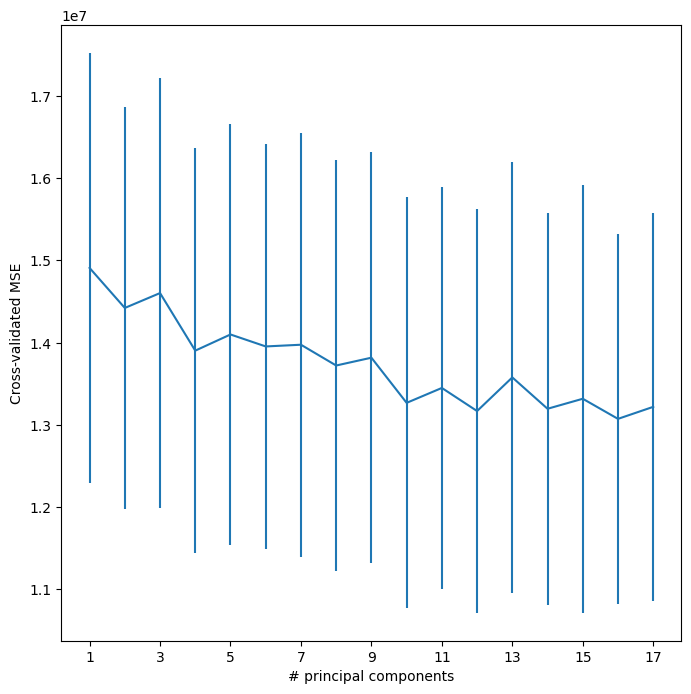

In [48]:
_, ax = subplots()
n_comp = params['pca__n_components']
ax.errorbar(
    n_comp, 
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp[::2]);

We use the # of component with lowest MSE

In [49]:
n_components = grid.best_params_['pca__n_components']
tunedPcrPipe = Pipeline([
    ('ohe', ohe_dense), 
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)), 
    ('lr', skl.LinearRegression())
])
tunedPcrPipe.fit(X, y)

,steps,"[('ohe', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [50]:
tunedPcrPipe.named_steps['lr'].coef_

array([ -35.50441095, -318.87720943, -204.08254606, -281.28028985,
        330.82881027,   62.75593875,   77.19130121,  -99.27476521,
         36.82179475, -128.1953791 , -181.52043351,   42.49588776,
         48.53117987,   63.1301488 ,    3.35261067,   47.83067172])

In [51]:
pcrScores = skm.cross_validate(
    tunedPcrPipe, X, y, cv=ss,
    scoring='neg_mean_squared_error',
    return_train_score=True,
)
-pcrScores['test_score'].mean(), -pcrScores['train_score'].mean()

(10231178.921428125, 11042789.738237863)

### PLS

In [52]:
plsPipe = Pipeline([
    ('ohe', ohe_dense), 
    ('scaler', StandardScaler()),
    ('pls', PLSRegression(n_components=2))
])
plsPipe.fit(X, y)

,steps,"[('ohe', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [53]:
plsPipe.named_steps['pls'].coef_

array([[ 159.31454099, -159.31454099,  -15.51431808, ...,   29.57654171,
           8.3869339 ,    8.24091105]])

In [54]:
params = {'pls__n_components': range(1, X.shape[1]+1)}
params

{'pls__n_components': range(1, 18)}

In [55]:
grid = skm.GridSearchCV(
    plsPipe, params, cv=k5fold, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"{'pls__n_components': range(1, 18)}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,categories,'auto'


In [56]:
grid.best_params_, grid.best_score_

({'pls__n_components': 1}, -11632194.225469938)

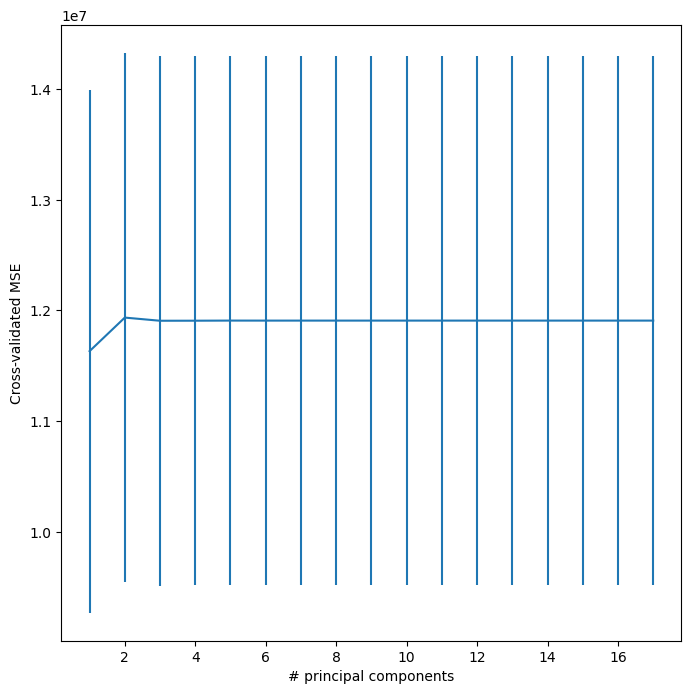

In [57]:
_, ax = subplots()
n_comp = params['pls__n_components']
ax.errorbar(
    n_comp, 
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components');

In [58]:
n_components = grid.best_params_['pls__n_components']
tunedPlsPipe = Pipeline([
    ('ohe', ohe_dense), 
    ('scaler', StandardScaler()),
    ('pls', PLSRegression(n_components=n_components))  
])

In [59]:
plsScores = skm.cross_validate(
    tunedPlsPipe, X, y, cv=ss,
    scoring='neg_mean_squared_error',
    return_train_score=True,
)
-plsScores['test_score'].mean(), -plsScores['train_score'].mean()

(8962407.433983892, 715905.986534547)

## Simulated data 2

### Simulated data

Simulated data from normal distribution.

In [60]:
p, N = 20, 1_000
x = rng.normal(size=(N, p))
x.shape

(1000, 20)

In [61]:
x_cols = [f"x{k}" for k in range(1, p+1)]

Beta terms $\beta$ where are equal to zero.

In [62]:
mask = rng.random(p) > .25
beta = rng.standard_normal(p) * mask
beta

array([ 0.79056056, -1.01187995,  0.21085388,  2.4695668 , -0.23927896,
        0.18673041, -1.66104026, -0.85297929,  0.4597207 , -0.32989774,
        0.61443296,  0.42493869, -0.        ,  1.01530628, -1.24268494,
       -0.76492191,  0.22948492,  1.56702301, -1.00387635,  0.14768445])

Noise term $\epsilon$.

In [63]:
e = rng.normal(size=N)
e.shape

(1000,)

Response vector $y$.

$y = X\beta + \epsilon$

In [64]:
y = x.dot(beta) + e
y.shape

(1000,)

Adding axis to $y$ so we can hstack with $x$.

In [65]:
y[np.newaxis,:].shape

(1, 1000)

In [66]:
sim2a = np.hstack((x, y[np.newaxis,:].T))
sim2a.shape

(1000, 21)

In [67]:
sim2_cols = x_cols+['y']
Sim2 = pd.DataFrame(sim2a, columns=sim2_cols)
Sim2.shape

(1000, 21)

In [68]:
y = Sim2.pop('y')
X = Sim2
y.shape, X.shape

((1000,), (1000, 20))

### Best subset selection

In [69]:
Xa, ya = np.asarray(X), np.asarray(y)

paths = fit_path(Xa, ya, max_nonzeros=Xa.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  1
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  2
Iteration: 6. Number of non-zeros:  2
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  4
Iteration: 9. Number of non-zeros:  4
Iteration: 10. Number of non-zeros:  7
Iteration: 11. Number of non-zeros:  7
Iteration: 12. Number of non-zeros:  7
Iteration: 13. Number of non-zeros:  7
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  10
Iteration: 19. Number of non-zeros:  10
Iteration: 20. Number of non-zeros:  10
Iteration: 21. Number of non-zeros:  10
Iteration: 22. Number of non-zeros:  11
Iteration: 23. Number of non-zeros:  11
Iteration: 24. Number of non-zeros:  11
Iteration: 25. Number of non-zero

In [70]:
paths[19]

{'B': array([ 0.80802539, -1.04970784,  0.        ,  2.43012071,  0.        ,
         0.        , -1.6143912 , -0.83563859,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.97088204, -1.27971199,
        -0.71678324,  0.        ,  1.47747747, -0.99061878,  0.        ]),
 'B0': 0.00666831221437883,
 'lambda_0': 0.007806793443672531,
 'M': 0.6320108299354048,
 'Time_exceeded': False}

Training predictions using paths.

In [71]:
train_mse = []
lambdas = []
for path in paths:
    yhat = path['B0'] + np.dot(X, path['B'])
    train_mse.append(mean_squared_error(y, yhat))
    lambdas.append(path['lambda_0'])

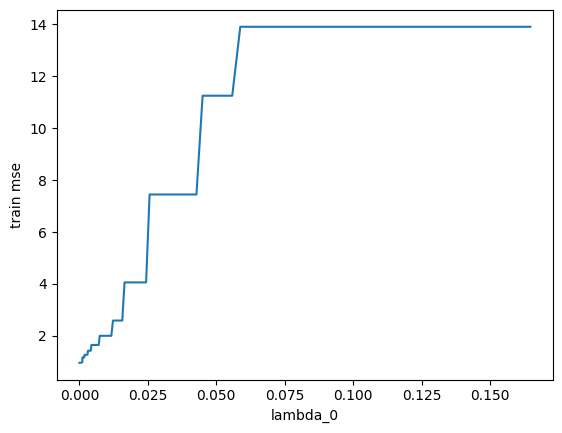

In [72]:
_, ax = subplots()
ax.set_xlabel('lambda_0')
ax.set_ylabel('train mse')
ax.plot(lambdas, train_mse);

TODO: Use the `paths` to fit on test set.

## Boston data

In [73]:
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [74]:
y = Boston.pop('crim')
X = Boston
y.shape, X.shape

((506,), (506, 12))

### Predicting per capita crime rate

#### Linear regression

Baseline model.

In [107]:
lr = skl.LinearRegression()
lrScores = skm.cross_validate(
    lr, X, y, cv=ss, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)
-lrScores['test_score'].mean(), -lrScores['train_score'].mean()

(38.963092469786694, 41.416093719860996)

#### Ridge

In [76]:
ridgeCV = skl.RidgeCV(cv=k5fold)
ridgePipe = Pipeline(steps=[
    ('scaler', scaler), 
    ('ridge', ridgeCV)
])
ridgePipe.fit(X, y)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alphas,"(0.1, ...)"
,fit_intercept,True
,scoring,None
,cv,KFold(n_split... shuffle=True)


In [77]:
ridgePipe.named_steps['ridge'].coef_

array([ 0.93919461, -0.50480646, -0.20606618, -0.90723007,  0.41622726,
       -0.02390368, -1.88132571,  4.65465442, -0.00919974, -0.53316464,
        1.0659517 , -1.77652167])

In [78]:
ridgeScores = skm.cross_validate(
    ridgePipe, X, y, cv=ss, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)
-ridgeScores['test_score'].mean(), -ridgeScores['train_score'].mean()

(38.64765260608597, 41.550957414687694)

#### Lasso

In [79]:
lasso = skl.LassoCV(cv=k5fold)
lassoPipe = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('lasso', lasso)
])
lassoPipe.fit(X, y)

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True


In [80]:
lassoPipe.named_steps['lasso'].coef_

array([ 1.02670419, -0.4164782 , -0.20140285, -1.08809775,  0.40894564,
       -0.        , -2.03722588,  5.1892287 , -0.48892571, -0.62482957,
        0.97901539, -1.94687999])

In [81]:
lassoScores = skm.cross_validate(
    lassoPipe, X, y, cv=ss,
    scoring='neg_mean_squared_error',
    return_train_score=True,
)
-lassoScores['test_score'].mean(), -lassoScores['train_score'].mean()

(39.23412876962873, 41.68969268270458)

#### PCR

In [82]:
pcrPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)), 
    ('lr', skl.LinearRegression())
])
pcrPipe

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'


In [83]:
params = {'pca__n_components': range(1, X.shape[1]+1)}
params

{'pca__n_components': range(1, 13)}

In [84]:
grid = skm.GridSearchCV(
    pcrPipe, params, cv=k5fold, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"{'pca__n_components': range(1, 13)}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [85]:
-grid.cv_results_['mean_test_score'].mean()

46.21217841483763

In [86]:
grid.best_params_, -grid.best_score_

({'pca__n_components': 12}, 42.66338158145378)

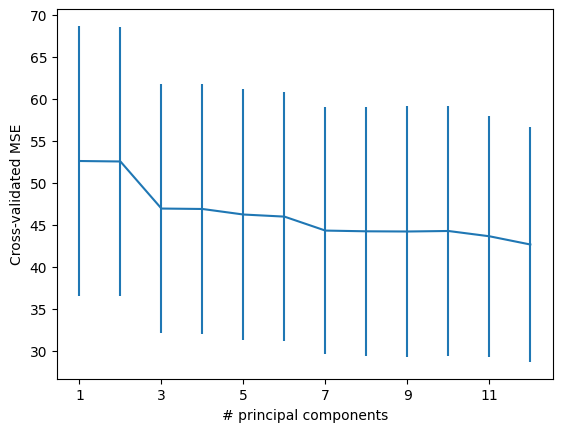

In [87]:
_, ax = subplots()
n_comp = params['pca__n_components']

ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp[::2]);

ax.errorbar(
    n_comp, 
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(K),
);

In [88]:
n_components = grid.best_params_['pca__n_components']
tunedPcrPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)), 
    ('lr', skl.LinearRegression())
])
tunedPcrPipe.fit(X, y)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,12
,copy,True
,whiten,False
,svd_solver,'auto'


In [89]:
tunedPcrPipe.named_steps['lr'].coef_

array([ 1.90306309, -0.27286546,  2.27730675,  0.6229764 , -0.96654028,
        0.82347487, -2.4643456 ,  0.50376805,  1.0057635 , -1.11344982,
       -2.47642992, -4.01145773])

In [108]:
pcrScores = skm.cross_validate(
    tunedPcrPipe, X, y, cv=ss,
    scoring='neg_mean_squared_error',
    return_train_score=True,
)
-pcrScores['test_score'].mean(), -pcrScores['train_score'].mean()

(38.96309246978672, 41.416093719860996)

In [155]:
explained_variance_ratio = tunedPcrPipe.named_steps['pca'].explained_variance_ratio_
explained_variance_ratio

array([0.49927632, 0.1371534 , 0.09298261, 0.07271505, 0.06619627,
       0.03423629, 0.02535274, 0.02196511, 0.01795572, 0.01545621,
       0.01152101, 0.00518927])

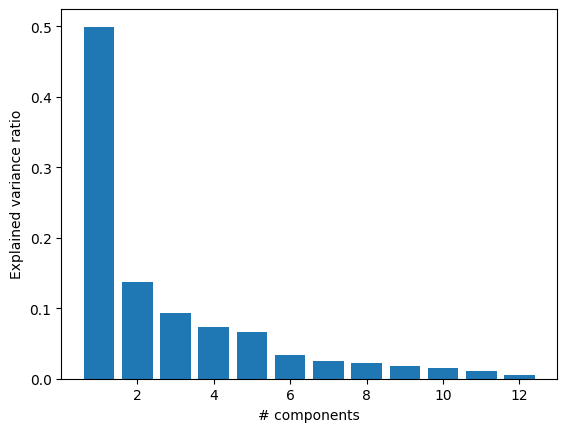

In [160]:
_, ax = subplots()
components = np.arange(1, len(explained_variance_ratio) + 1)
ax.bar(components, explained_variance_ratio)
ax.set_xlabel('# components')
ax.set_ylabel('Explained variance ratio');

#### PLS

In [91]:
plsPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pls', PLSRegression(n_components=2))
])
plsPipe

,steps,"[('scaler', ...), ('pls', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,scale,True
,max_iter,500
,tol,1e-06


In [92]:
params = {'pls__n_components': range(1, X.shape[1]+1)}
params

{'pls__n_components': range(1, 13)}

In [93]:
grid = skm.GridSearchCV(
    plsPipe, params, cv=k5fold, n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"{'pls__n_components': range(1, 13)}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [94]:
-grid.cv_results_['mean_test_score'].mean()

43.65088123406837

In [95]:
grid.best_params_, -grid.best_score_

({'pls__n_components': 9}, 42.63962246466635)

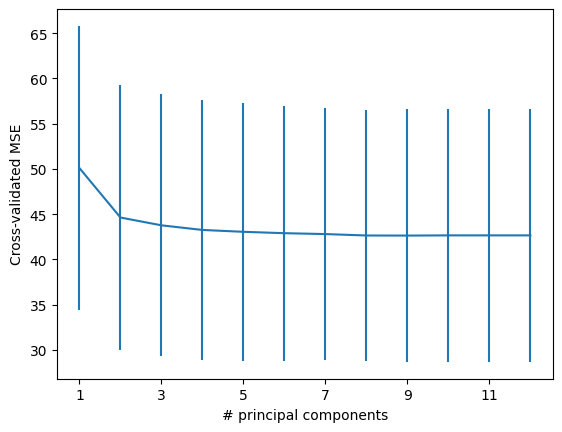

In [96]:
_, ax = subplots()
n_comp = params['pls__n_components']

ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp[::2])

ax.errorbar(
    n_comp, 
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(K),
);

In [97]:
n_components = grid.best_params_['pls__n_components']
tunedPlsPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pls', PLSRegression(n_components=n_components))  
])
tunedPlsPipe.fit(X, y)

,steps,"[('scaler', ...), ('pls', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,9
,scale,True
,max_iter,500
,tol,1e-06


In [98]:
tunedPlsPipe.named_steps['pls'].coef_

array([[ 1.04997084e+00, -4.11340862e-01, -2.06954343e-01,
        -1.17278728e+00,  4.32592584e-01,  4.93240060e-03,
        -2.12095994e+00,  5.31850287e+00, -5.96109103e-01,
        -6.82318890e-01,  9.41893699e-01, -2.05526832e+00]])

In [109]:
plsScores = skm.cross_validate(
    tunedPlsPipe, X, y, cv=ss,
    scoring='neg_mean_squared_error',
    return_train_score=True,
)
-plsScores['test_score'].mean(), -pcrScores['train_score'].mean()

(38.962964814957445, 41.416093719860996)

### Conclusion

Ridge and lasso performed well on the data, while PCR and PLS have similar test MSE to the baseline model.

Accordingly, below are features that have non-zero coefficient in lasso.

In [100]:
nzfeats = Boston.columns[np.where(lassoPipe.named_steps['lasso'].coef_ != 0.0)[0]]
nzfeats

Index(['zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio',
       'lstat', 'medv'],
      dtype='object')

Out of curiousity, we fit a Ridge and Lasso without the above features to see if the score would improve.

In [101]:
Xhat = X[nzfeats]
Xhat.shape, X.shape

((506, 11), (506, 12))

Ridge with only non-zero features.

In [102]:
ridgeScores = skm.cross_validate(
    ridgePipe, Xhat, y, cv=ss, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)

Lasso with only non-zero features.

In [103]:
lassoScores = skm.cross_validate(
    lassoPipe, Xhat, y, cv=ss, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)

Sure enough, the scores for both ridge and lasso has improved.

In [104]:
-ridgeScores['test_score'].mean(), -lassoScores['test_score'].mean()

(38.50856915336543, 39.25059132004226)

In [105]:
lassoPipe.fit(Xhat, y)

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True


We verify that all the features have non-zero coefficient.

In [106]:
lassoPipe.named_steps['lasso'].coef_

array([ 1.04581369, -0.40893147, -0.20550248, -1.12138815,  0.42229151,
       -2.07653568,  5.25479123, -0.5576355 , -0.64068257,  0.98060834,
       -1.98182436])

We also plot the learning curve for the ridge pipeline.

In [152]:
train_sizes, train_scores, test_scores = skm.learning_curve(
    ridgePipe, X, y, cv=k5fold, scoring='neg_mean_squared_error',
)

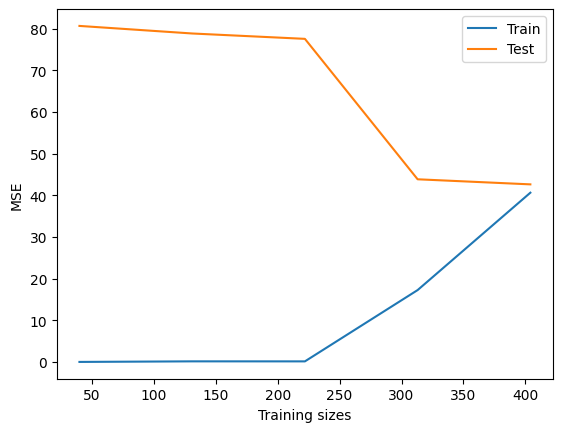

In [153]:
_, ax = subplots()
ax.plot(train_sizes, -train_scores.mean(axis=1), label='Train')
ax.plot(train_sizes, -test_scores.mean(axis=1), label='Test')
ax.set_xlabel('Training sizes')
ax.set_ylabel('MSE')
ax.legend();